### Comments

**TO DO**
* Batch?!
* fine tuning des params --> pas optimisé pour le moment
* try different architecture
* Use genre as features and build network on Cast, Crew, Keywords?
* Skip Connections ? Batch Norm ? 

# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.utils import resample
from sklearn.decomposition import PCA

import random

import dgl.function as fn
from dgl import DGLGraph
import dgl.nn.pytorch as dgl_nn
import dgl.transform as dgl_transform

import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

Data_path = 'Data/'

### Loading the similarity matrix and generate graph

In [2]:
# Load similarity matrix
#file = open(Data_path + 'Adjacency_matrix.pickle','rb')
#file = open(Data_path + 'Adjacency_matrix_G99CCK05.pickle', 'rb')
file = open(Data_path + 'Adjacency_matrix_all025.pickle', 'rb')
adj_mat =  pickle.load(file)

# Generate graph
G = DGLGraph(graph_data=adj_mat)
G = dgl_transform.add_self_loop(G)

### Loading features and labels

In [3]:
features_df = pd.read_csv(Data_path + 'features.csv',index_col=0).drop(columns = ['title'])

labels_df = pd.read_csv(Data_path + 'labels.csv',index_col=0).drop(columns = ['title', ])

keep only some features

In [4]:
features_df = features_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]

The labels is whether the movie is nominated for an Oscare or a GoldenGlobes 

In [5]:
#labels_df['Nominations'] = labels_df['Nominations_Oscars'] + labels_df['Nominations_GoldenGlobes']

In [6]:
# features
tensor_data = torch.FloatTensor(features_df.values)

# labels
IMDB_nom = labels_df['Nominations'].copy()
IMDB_nom.loc[IMDB_nom > 0] = 1
tensor_labels = torch.LongTensor(IMDB_nom.values)

In [7]:
# Just checking class imbalance
IMDB_nom.value_counts() # 18.263 % of CLASS 1

0.0    3728
1.0    1074
Name: Nominations, dtype: int64

In [8]:
'''# Separate majority and minority classes
df_majority = IMDB_nom[IMDB_nom==0]
df_minority = IMDB_nom[IMDB_nom==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=877,     # to match minority class
                                 random_state=1) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

adj_mat_bal = adj_mat[df_downsampled.index,:]
adj_mat_bal = adj_mat_bal[:,df_downsampled.index]
G = DGLGraph(graph_data=adj_mat_bal)

G = dgl_transform.add_self_loop(G)

tensor_feat = torch.FloatTensor(features_df.iloc[df_downsampled.index,:].values)
tensor_labels = torch.LongTensor(df_downsampled.values)'''

'# Separate majority and minority classes\ndf_majority = IMDB_nom[IMDB_nom==0]\ndf_minority = IMDB_nom[IMDB_nom==1]\n \n# Downsample majority class\ndf_majority_downsampled = resample(df_majority, \n                                 replace=False,    # sample without replacement\n                                 n_samples=877,     # to match minority class\n                                 random_state=1) # reproducible results\n \n# Combine minority class with downsampled majority class\ndf_downsampled = pd.concat([df_majority_downsampled, df_minority])\n \n# Display new class counts\ndf_downsampled.value_counts()\n# 1    49\n# 0    49\n# Name: balance, dtype: int64\n\nadj_mat_bal = adj_mat[df_downsampled.index,:]\nadj_mat_bal = adj_mat_bal[:,df_downsampled.index]\nG = DGLGraph(graph_data=adj_mat_bal)\n\nG = dgl_transform.add_self_loop(G)\n\ntensor_feat = torch.FloatTensor(features_df.iloc[df_downsampled.index,:].values)\ntensor_labels = torch.LongTensor(df_downsampled.values)'

### Generate masks and split train, val, test

In [9]:
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)

for prov_index, test_index in sss1.split(tensor_data, tensor_labels):
    prov_mask = prov_index
    test_mask = test_index

for train_index, val_index in sss2.split(tensor_data[prov_mask], tensor_labels[prov_mask]):
    train_mask = train_index
    val_mask = val_index

### Building Graph Neural Network

In [10]:
#  model: Combine GraphConv layers first then two fully connected layers --> seems less stable over epochs
class Linear_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers --> as much GraphConv as diameter --> reach everywhere
        self.linear = nn.Linear(self._in_feats, 16)
        self.gcn1 = dgl_nn.conv.GraphConv(16, 32, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn6 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn7 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn8 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn9 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn10 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn11 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.linear1 = nn.Linear(32, self._out_feats)#self._hidden_size)
        self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = F.relu(self.linear(feat))
        h = self.gcn1(graph, h)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = self.gcn6(graph, h)
        h = self.gcn7(graph, h)
        h = self.gcn8(graph, h)
        h = self.gcn9(graph, h)
        h = self.gcn10(graph, h)
        h = self.gcn11(graph, h)
        h = self.linear1(h)
        #h = F.relu(h)
        #h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 

# Model : Only GraphConv layers --> seems more stable
class Pure_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.gcn1 = dgl_nn.conv.GraphConv(self._in_feats, 32, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn6 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn7 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn8 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn9 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn10 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn11 = dgl_nn.conv.GraphConv(32,  self._out_feats, activation=None)
        
    def forward(self, graph, feat):
        h = self.gcn1(graph, feat)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = self.gcn6(graph, h)
        h = self.gcn7(graph, h)
        h = self.gcn8(graph, h)
        h = self.gcn9(graph, h)
        h = self.gcn10(graph, h)
        h = self.gcn11(graph, h)
        h = F.log_softmax(h, dim=1)
        return h 

# model : Use and APPNP layer with k=7 (the network diameter) followed by 2 fully connected linears. 
class Simple_APPNP(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int, k: int):
        super().__init__()
        self._k = k
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.appnpconv1 = dgl_nn.conv.APPNPConv(self._k, 0.1, 0) #alpha teleport proba = 0.1 (cf paper)
        self.linear1 = nn.Linear(self._in_feats, self._hidden_size)
        self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = self.appnpconv1(graph, feat)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 

In [11]:
def train(model, g, features, labels, train_mask, loss_fcn, optimizer):
    """ TO DO : add doctring """
    model.train()  
    
    pred = model(g, features) # prediction
    loss = loss_fcn(pred[train_mask], tensor_labels[train_mask])
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, mask, labels):
    """  TO DO : add docstring """
    model.eval()  
    
    with torch.no_grad():
        pred = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(pred, dim=1)
        correct = torch.sum(indices == labels)
        acc = correct.item() * 1.0 / len(labels) #not the best metric
        f1 = f1_score(labels, indices)
        recall = recall_score(labels, indices)
        precision = precision_score(labels, indices)
        
        return acc, recall, precision, f1

In [12]:
# check network diameter --> take a lot of time to run 
import networkx as nx
Gnx = nx.from_numpy_array(adj_mat)
G_large = max(nx.connected_component_subgraphs(Gnx), key=len)
#d = nx.diameter(G_large) 
#print(f'diameter : {d}')

In [13]:
# Fixed values
in_feats = tensor_data.shape[1]
out_feats = 2

# Not relevant parameters
n_epochs = 700
# To tune
k = 6 # number of hop (how far to look) usually best to use the network diameter (according to paper)
lr = 1e-4
lr2 = 2e-5
lr3 = 8e-6
weight_decay = 5e-6
#p_dropout = 0 # for now not doing it

hidden_size = 128
true_ratio = 1074/4802 # <-- fraction of Nominations
weights_loss = torch.FloatTensor([true_ratio, 1-true_ratio]) # to rebalance

Epoch 10 | Train Loss 18730.600 | Val Accuracy 24.7074% | Val recall  100.0000% |  Val  precision 24.7074% | Val f1 39.6246% |
Epoch 20 | Train Loss 6631.865 | Val Accuracy 24.7074% | Val recall  100.0000% |  Val  precision 24.7074% | Val f1 39.6246% |
Epoch 30 | Train Loss 1198.853 | Val Accuracy 74.1222% | Val recall  1.5789% |  Val  precision 20.0000% | Val f1 2.9268% |
Epoch 40 | Train Loss 355.242 | Val Accuracy 25.6177% | Val recall  99.4737% |  Val  precision 24.8684% | Val f1 39.7895% |
Epoch 50 | Train Loss 402.846 | Val Accuracy 68.4005% | Val recall  5.7895% |  Val  precision 14.6667% | Val f1 8.3019% |
Epoch 60 | Train Loss 241.590 | Val Accuracy 57.6073% | Val recall  30.5263% |  Val  precision 23.0159% | Val f1 26.2443% |
Epoch 70 | Train Loss 156.443 | Val Accuracy 41.3524% | Val recall  65.2632% |  Val  precision 24.3615% | Val f1 35.4793% |
Epoch 80 | Train Loss 140.928 | Val Accuracy 59.5579% | Val recall  27.8947% |  Val  precision 23.3480% | Val f1 25.4197% |
Epoch 

Epoch 680 | Train Loss 23.688 | Val Accuracy 65.7997% | Val recall  28.9474% |  Val  precision 30.0546% | Val f1 29.4906% |
Epoch 690 | Train Loss 23.575 | Val Accuracy 65.9298% | Val recall  29.4737% |  Val  precision 30.4348% | Val f1 29.9465% |
Epoch 700 | Train Loss 23.460 | Val Accuracy 65.7997% | Val recall  28.9474% |  Val  precision 30.0546% | Val f1 29.4906% |

Test 
 	|---- Accuracy 70.3434% 
 	|---- Recall 32.0930% 
 	|---- Precision 33.1731% 
 	|---- F1-score 32.6241%


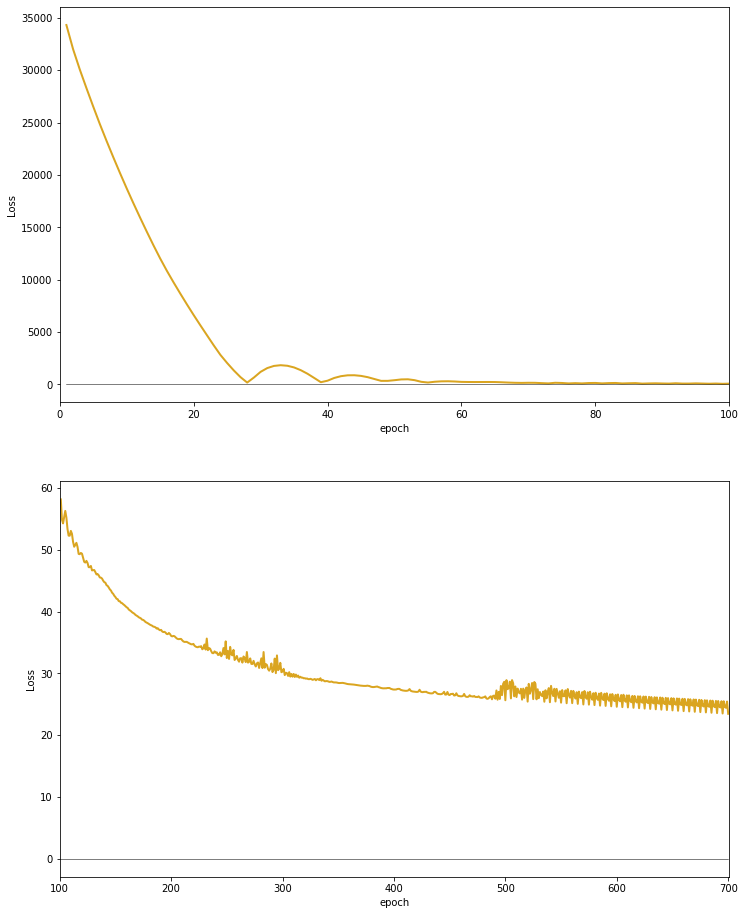

In [14]:
model = Linear_GNN(in_feats, out_feats, hidden_size)
#model = Simple_APPNP(in_feats, out_feats, hidden_size, k)

loss_fcn = torch.nn.NLLLoss(weight=weights_loss)
optimizer = torch.optim.Adam(model.parameters(),
                                                  lr=lr)
                                                  #weight_decay=weight_decay)
losses = []
for epoch in range(n_epochs):
    # adapt learning rate
    if epoch == 100: 
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr2
    elif epoch == 300: 
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr3
    
    loss = train(model, G, tensor_data, tensor_labels, train_mask, loss_fcn, optimizer)
    losses.append(loss.item())
    acc, recall, precision, f1 = evaluate(model, G, tensor_data, val_mask, tensor_labels)
    
    if (1+epoch)%10 == 0:
        print(f"Epoch {epoch+1} | Train Loss {loss.item():.3f} |", \
                f"Val Accuracy {acc:.4%} | Val recall  {recall:.4%} |", \
                f" Val  precision {precision:.4%} | Val f1 {f1:.4%} |")

print()
acc, recall, precision, f1 = evaluate(model, G, tensor_data, test_mask, tensor_labels)
print(f"Test \n \t|---- Accuracy {acc:.4%} \n \t|---- Recall {recall:.4%} \n \t|---- Precision {precision:.4%} \n \t|---- F1-score {f1:.4%}")

# Plot the loss
fig, axs = plt.subplots(2,1,figsize=(12,16))
ep = np.arange(1,n_epochs+1,1)
axs[0].plot(ep[0:100], losses[0:100], color='Goldenrod', linewidth=2)
axs[0].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[0].set_xlim([0,100])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(ep[100:], losses[100:], color='Goldenrod', linewidth=2)
axs[1].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[1].set_xlim([100,n_epochs+1])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Loss')

plt.show()